In [1]:
#!/usr/bin/Rscript
suppressPackageStartupMessages({
    library(tidyverse)
    library(GenomicRanges)
    library(GenomicFiles)
    library(rtracklayer)
    library(data.table)
    library(scales)
});
options(repr.plot.width=2, repr.plot.height=2, jupyter.plot_mimetypes = "image/svg+xml");
options(contrasts=c("contr.sum","contr.poly"));
theme_set(theme_classic(base_family = "Lucida Sans"));

In [2]:
# load info on which elements are called active
Summary = read.csv("./data/K562_eSTARR_voom.csv", header=T);
# focus on elements from TRE batch 4.
# In this batch, each element has A, B, C clones,
# such that A = B + C sequences.
TRE4 = Summary[ substr(Summary$ID, 1, 4) == "TRE4", ];
# count number of unique elements
length( na.omit(unique(as.integer(substr( TRE4$ID, 6, 9)))) );
# how many are active?
ActiveN = TRE4$ID[ TRE4$call == "Enhancer" ];
ActiveN = na.omit(unique(as.integer(substr(ActiveN, 6, 9))));
length(ActiveN);

[1] 100

[1] 45

In [3]:
head(TRE4)

,logFC.CW,ID,p.CW,logFC.CCW,p.CCW,logFC,call,Size
,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>
7,2.979538,TRE4_0035A,7.519773e-18,4.503000,1.939135e-23,3.933660,Enhancer,473
10,3.634642,TRE4_0173A,7.570820e-20,4.021269,3.096222e-21,3.840869,Enhancer,490
11,3.361270,TRE4_0041A,9.327936e-18,4.184769,1.151560e-18,3.830996,Enhancer,1362
13,3.192233,TRE4_0083A,2.688087e-15,4.204990,4.116449e-19,3.785713,Enhancer,950
14,1.799056,TRE4_0040A,1.125884e-10,4.522079,1.894881e-22,3.725539,Enhancer,591
20,3.442274,TRE4_0193A,6.192309e-20,3.663122,7.605952e-21,3.556920,Enhancer,776


In [4]:
# rather than recomputing raw activity, use logFC from previous analyses
rawact = read.csv("./data/K562_eSTARR_counts.csv", header=T);
rawact = as.data.frame( rawact[ substr(rawact$ID, 1, 4) == "TRE4", ]);
rawact$Size = TRE4[match(rawact$ID,TRE4$ID),"Size"];
isCW = rawact$Dir == "CW";
rawact[isCW,"Activity"]  = TRE4[match(rawact[ isCW,"ID"],TRE4$ID),"logFC.CW"];
rawact[!isCW,"Activity"] = TRE4[match(rawact[!isCW,"ID"],TRE4$ID),"logFC.CCW"];
rawact$logFC=NULL;

# only use CW, since subclones weren't tested in CCW
enhraw = rawact %>%
    filter( Dir == "CW" ) %>%
    mutate( enum=as.integer(substr(ID, 7, 9)),
            Dir=NULL,
            batch=substr(ID, 11, 11),
            letter=substr(ID, 10, 10) ) %>%
    arrange(enum);

In [7]:
# batch 2 = incorrect subclone boundaries
enh.dat = data.table(enhraw %>% filter(batch != 2 | letter=="A"));
# look at all tested clones for this element number
enh.dat[, allC := .(paste0(unique(letter), collapse="")), by=enum ];
enh.dat = enh.dat[ nchar(allC) > 2, ];
enh.dat = enh.dat[ allC == "ABC", ];
#head(enh.dat);

In [8]:
# max subclone activity
e1 = enh.dat[letter!='A', .(x=max(Activity)), by=.(enum)][,x];
# min subclone activity
e2 = enh.dat[letter!='A', .(x=min(Activity)), by=.(enum)][,x];
y  = enh.dat[letter=='A', .(enum, y=Activity), by=.(enum)]
dat = na.omit(data.frame( num=y[,enum], e1=e1, e2=e2, y=y[,y] ));
dat = dat[order(dat$num),];

Warning message:
“Removed 4 rows containing missing values (geom_point).”

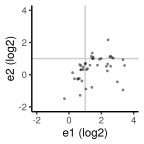

In [9]:
dat %>%
    ggplot(aes(e1, e2)) +
    xlim(-2, 4) + ylim(-2, 4) +
    xlab("e1 (log2)") + ylab("e2 (log2)") +
    geom_hline(aes(yintercept=1), col="#cccccc") +
    geom_vline(aes(xintercept=1), col="#cccccc") +
    geom_point(alpha=0.5, size=0.5, pch=16);
#ggsave("./TRE4_E1vs2.pdf", width=2, height=2);

Warning message:
“Removed 4 rows containing missing values (geom_point).”

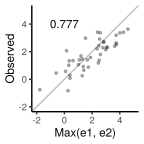

In [15]:
corrc = round( cor.test(dat$e1, dat$y)$estimate^2, 3);
dat %>% ggplot(aes(esum, y)) +
    xlim(-2, 5) + ylim(-2, 5) +
    xlab("Max(e1, e2)") + ylab("Observed") +
    geom_abline( slope=1, col="gray" ) +
    geom_point(alpha=0.3, size=0.5, pch=19) +
    geom_text(aes( 0, 4, label = corrc ), data=data.frame(), parse = T );
#ggsave("./TRE4_EnhRawMax.pdf", width=2, height=2);

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

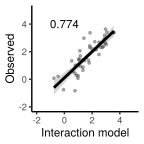

In [16]:
intm = lm(y ~ e1 * e2, data=dat);
corrc = round( summary(intm)$adj.r.squared, 3);
dat %>% ggplot(aes(intm$fitted, y)) +
    xlim(-2, 5) + ylim(-2, 5) +
    geom_smooth( method='lm', col='black' ) +
    xlab("Interaction model") + ylab("Observed") +
    geom_point(alpha=0.3, size=0.5, pch=19) +
    geom_text(aes( 0, 4, label = corrc ), data=data.frame(), parse = T );
#ggsave("./TRE4_EnhInteractionModel.pdf", width=2, height=2);

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

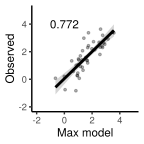

In [17]:
maxm = lm(y ~ e1, data=dat);
corrc = round( summary(maxm)$adj.r.squared, 3);

dat %>% ggplot(aes(maxm$fitted, y)) +
#    geom_line( aes(x=0:6, y=0:6), data=data.frame(), col="gray" ) +
    xlim(-2, 5) + ylim(-2, 5) +
    geom_smooth( method='lm', col="black" ) +
    xlab("Max model") + ylab("Observed") +
    geom_point(alpha=0.3, size=0.5, pch=19) +
    geom_text(aes( 0, 4, label = corrc), data=data.frame() );
#ggsave("./TRE4_EnhMaxModel.pdf", width=2, height=2, device=cairo_pdf);

In [18]:
# in interaction model, only the max subclone
# e1 is predictive!
summary(intm);


Call:
lm(formula = y ~ e1 * e2, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.5987 -0.4421 -0.0083  0.4010  1.5729 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.31582    0.19149   1.649    0.107    
e1           0.89817    0.10725   8.374 1.69e-10 ***
e2           0.09824    0.08846   1.111    0.273    
e1:e2        0.05137    0.04926   1.043    0.303    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6563 on 42 degrees of freedom
Multiple R-squared:  0.7892,	Adjusted R-squared:  0.7742 
F-statistic: 52.43 on 3 and 42 DF,  p-value: 2.965e-14


In [19]:
summary(maxm);


Call:
lm(formula = y ~ e1, data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.66290 -0.40470 -0.06771  0.44765  1.63142 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.31696    0.13775   2.301   0.0262 *  
e1           0.94786    0.07649  12.392 6.03e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6592 on 44 degrees of freedom
Multiple R-squared:  0.7773,	Adjusted R-squared:  0.7722 
F-statistic: 153.6 on 1 and 44 DF,  p-value: 6.031e-16


In [20]:
# compare interaction and max model
anova(intm, maxm);
# interaction model isn't more predictive, implying
# negligible contribution of weaker subelement!

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
42,18.09236,NA,NA,NA,NA
44,19.11884,-2,-1.026481,1.191448,0.313839
